# 1. Notebook Setup

Once you have downloaded all the data onto your local machine, you can continue with this notebook

## Imports

In the first step, we only important some Python packages and create a Spark session.

In [1]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm

## Directories

Here we setup the directories which point to the source data and to intermediate directories. Note that we also set a `spark_tempdir` directory where Spark can spill data to. That directory should have at least 150GB of free space.

In [2]:
# Source directory where all downloaded data is stored in
weather_basedir = "file:///dimajix/data/weather-noaa"

# Output directory for intermediate results and aggregations
structured_basedir = "file:///srv/ssd/dimajix/weather-dwh"

# Temporary directory for Spark
spark_tempdir = "/srv/ssd/tmp/jupyter-spark"

The intermediate directories are located below the `structured_basedir` path and will contain derived data. Since our data set is rather large, persisting intermediate transformations and preaggregates will speed up our work significantly.

In [3]:
hourly_weather_location = os.path.join(structured_basedir, "weather-measurements")
stations_location = os.path.join(structured_basedir, "weather-stations")
daily_weather_location = os.path.join(structured_basedir, "daily-weather-measurements")
daily_country_weather_location = os.path.join(structured_basedir, "daily-country-weather-measurements")

## Spark Session

Finally a Spark session is created. You might want to adjust the settings, I used Spark local mode with 48GB RAM.

In [4]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

if not 'spark' in locals():
    spark = SparkSession.builder \
        .master("local[*]") \
        .config("spark.driver.memory","48G") \
        .config("spark.local.dir", spark_tempdir) \
        .getOrCreate()

spark

# 2. Load Data

In [5]:
country = "GM"

In [6]:
# Read in data again and filter for selected country
daily_country_weather = spark.read.parquet(daily_country_weather_location).filter(f.col("CTRY") == country)
daily_country_weather.printSchema()

root
 |-- CTRY: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- date: date (nullable = true)
 |-- min_temperature: double (nullable = true)
 |-- max_temperature: double (nullable = true)
 |-- avg_temperature: double (nullable = true)
 |-- min_wind_speed: double (nullable = true)
 |-- max_wind_speed: double (nullable = true)
 |-- avg_wind_speed: double (nullable = true)



# 3. Yearly Average Temperature

Now we can calculate the average temperature per year of the selected country.

In [7]:
yearly_weather = daily_country_weather \
    .withColumn("year", f.year(f.col("date"))) \
    .groupBy("year").agg(
        f.avg(f.col("avg_temperature")).alias("avg_temperature"),
        f.avg(f.col("avg_wind_speed")).alias("avg_wind_speed"),
        f.avg(f.col("max_wind_speed")).alias("max_wind_speed")
    )\
    .orderBy(f.col("year")).toPandas()

yearly_weather.set_index("year", drop=True, inplace=True)

## 3.1 Plot

<AxesSubplot:xlabel='year', ylabel='avg_temperature'>

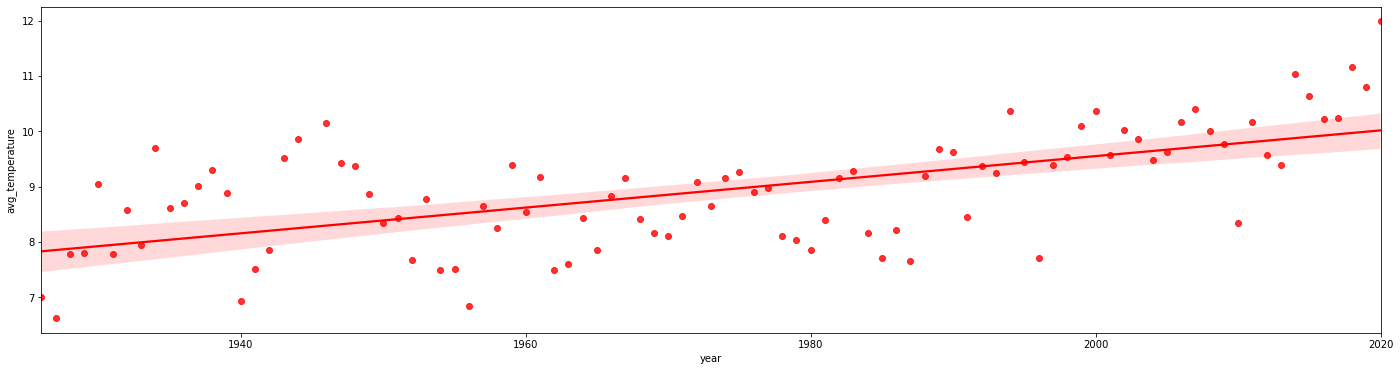

In [8]:
plt.figure(figsize=(24,6))
sns.regplot(x=yearly_weather.index, y=yearly_weather["avg_temperature"], color="r")

## 3.2 Identifying new Records

<Figure size 1728x432 with 0 Axes>

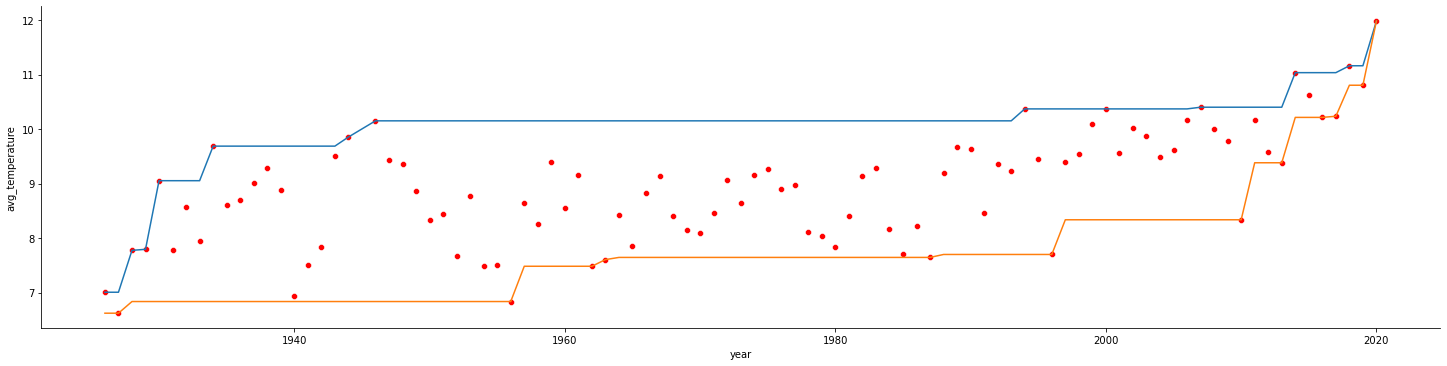

In [9]:
running_max = yearly_weather["avg_temperature"].expanding().max()
running_min = yearly_weather["avg_temperature"][::-1].expanding().min()[::-1]

plt.figure(figsize=(24,6))
sns.relplot(x=yearly_weather.index, y=yearly_weather["avg_temperature"], color="r", aspect=4)
plt.plot(running_max)
plt.plot(running_min)

## 3.3 Number of Records

In [10]:
def count_max_records(series):
    running_max = series.expanding().max()
    records = running_max > running_max.shift(1)
    return records.sum() + 1

def count_min_records(series):
    running_min = series.expanding().min()
    records = running_min < running_min.shift(1)
    return records.sum() + 1

In [13]:
len(yearly_weather.index)

94

In [11]:
count_max_records(yearly_weather["avg_temperature"])

12

In [12]:
count_min_records(yearly_weather["avg_temperature"][::-1])

12

### Expected Number of Mimima / Maxima

In [24]:
def harmonic_sum(n): 
    i = 1
    s = 0.0
    for i in range(1, n+1): 
        s = s + 1/i; 
    return s; 
  
harmonic_sum(len(yearly_weather.index))

5.125820165099301

### Distribution of Number of Minima using Monte Carlo

In [27]:
num_samples = 10000
permutation_size = len(yearly_weather.index)

samples = np.zeros(num_samples, dtype=int)


for i in range(0,num_samples):
    p = np.random.permutation(permutation_size)
    num_maximums = count_max_records(pd.Series(p))
    samples[i] = num_maximums

<AxesSubplot:ylabel='Count'>

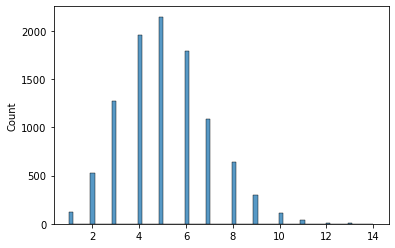

In [28]:
sns.histplot(data=samples)

In [29]:
from statsmodels.distributions.empirical_distribution import ECDF

ecdf = ECDF(samples)

### Probability of having 12 or more Maximums/Minimums

In [34]:
1 - ecdf(11)

0.0012999999999999678

In [35]:
ecdf.mean()

AttributeError: 'ECDF' object has no attribute 'mean'